<a href="https://colab.research.google.com/github/ebriggsjohnson/MSQM_Contest/blob/main/Chinese_name_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Roughly stated, Chinese names are distinct from English names in two ways: First, there are a relatively smaller number of family names. The top 100 surnames in America cover 16.5% of the population (1). In Chinese speaking Taiwan, the top 10 surnames alone cover around 50% of the population (2).

For given names, parents generally have much leeway. In practice, most English speakers choose from a fixed corpus of given names, most of which are strongly associated with a gender. Although names may ebb and flow in popularity, more creative names rarely go from non-existant to common. In Chinese, there is almost an infinite variety of possible given names, although as we will see, cultural, regional, and historical trends do exist. Certain characters are also much more strongly associated with "male" or "female", although there are few hard and fast rules.

This means that for English speakers, there is a wealth of hidden information in Chinese names (how old are they? what is their gender? what part of China are they from?), with much business, social, and educational value. If a user signs up for your company as Zhang Wei, what can you predict about him just based on that? Adding to the complexity, most Chinese users will Romanize their name using the Hanyu Pinyin transliteration system without tone markings, and information is also lost in that process. For example, 张伟 and 张薇 would both written as Zhang Wei -- they are distinct in the original Chinese, but the same after Romanization.

There is a Python package that attempts to predict gender based on a Pinyin name (3). But I want to expand on that by 1) what other information can you predict, given only Pinyin and 2) if you are lucky enough to get the name in Chinese characters, what can you predict? 3) the existing python package only works with traditional Chinese and was built with a corpus of Taiwanese names, we should not assume that naming practices are the same in both Mainland and Taiwan contexts. And maybe I can beat their high score :)

As a foreign learner of Chinese, I also find this intellectually interesting. So let's dive in.



1: https://en.wikipedia.org/wiki/Lists_of_most_common_surnames_in_North_American_countries

2: https://en.wikipedia.org/wiki/Chinese_surname

3: https://pypi.org/project/namesex/


I am using two
 main data sources:
The first has its origins in a study by Dongbo Shi and  Sherry T. Tong. It is public domain and available at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/UAARYY
It is aggregated from from 30,282,623 individuals who are shareholders of Chinese firms registered with the State Administration for Industry and Commerce (SAIC) until 2018.

The second is from Bruce H. W. S. Bao's R package entitled ChineseNames (https://github.com/psychbruce/ChineseNames), which was "provided by Beijing Meiming Science and Technology Company (through private collaboration) and originally obtained from the National Citizen Identity Information Center (NCIIC) of China in 2008. It contains nationwide frequency statistics of almost all Chinese surnames and given-name characters, which have covered about 1.2 billion Han Chinese population (96.8% of the Han Chinese population born from 1930 to 2008 and still alive in 2008, i.e., the living household-registered population). It also contains subjective rating indices of given-name characters".

## Testing Data
For testing our models, I have decided to use combine two different training sets. While this is a little unscientific, it was driven by practical concerns – it’s hard to find a public list of real names and birthdays. I have combined the aforementioned list of 10,000 adolescents with birth year and gender, with the list of sample of current representatives to the National People’s Congress that I manually (yes, by hand...) entered from Wikipedia.

The adolscent data is an original publication by the Bao, the publisher of the second data set. Although he claims it is useless compared to his new data set, because it includes information on name collocations while his second data set only gives information by character, I think he might by wrong. It's a list of the full names of 9000 Chinese adolescent with year of birth, and thus represents a rare case of good, public testing data. Full names and birthdates. https://www.researchgate.net/publication/269630594_9800_Chinese_Names_with_Gender_NOTE_this_small_dataset_is_deprecated_a_new_R_package_ChineseNames_is_available


Since all the tricks I could think of to extract the tables cleanly from Wikipedia weren't working, I manually entered the list of current delegates to the 14th National People's Congress. https://en.wikipedia.org/wiki/14th_National_People%27s_Congress

The first list is gender balanced but skews young, the second list is male dominated and skews older. My hope is that combining them gives us a decent proxy to real world test data, although I can certainly imagine countless biases that might slip in to these data sets. If I had more resources, a better test set would be one of my higher priorities.



First, to summarize the data:
df_cngender has about 6 million rows. Each row tells us an individuals name in Chinese_name and year of birth (the first four digits of b_year_clean). The row doesn't tell us their gender directly, but rather gives us a lookup table of sorts. If we have a name, we can find a row that matches it, and look up in count_char_[decade_start_year] and count_char[decade_begin_year]. This should give us a count of all the names in the database that have those characters, by decade. We can also look up char_male_prob_[year]-[year] for every decade from 1920 to 2000, and get the probability of it being a male in each of those decades. I don't know why the same name has slightly different probabilities for different rows. Perhaps I am misunderstanding the data, but I think it's about the same.

df_cnpinyin is the same thing, but with names automatically converted to Pinyin.

df_familyname has two useful columns, surname, and ppm.1930_2008 which shows its parts per millions, basically a score of how common a surname is

df_givenname has individual characters (NOT whole names) in "character". So after breaking down a given name into characters, you can look up each character and find its corresponding name gender score in name.gender. This is calculated as NG = (Nmale – Nfemale) / (Nmale + Nfemale), so it ranges from -1 to 1. -1 would indicate a character that never appears in a male name. We also have PPM counts by decade in these columns: ppm.1930_1959	ppm.1960_1969	ppm.1970_1979	ppm.1980_1989	ppm.1990_1999	ppm.2000_2008

df_top1000name_prov gives us full given names (not just individual characters) in name, gives us the count in each chinese direct administered city / province / autonomous region, as well as the count of men and women.

top100name.year gives a list of the 100 most common female names and male names by decade
top50char.year gives us a list of the top 50 most common characters in female names and male names, by decade

and df_10_000_adolescent_names gives us full names (including last name) in 姓名, as well as gender in the 性别 column (男 for male 女 for female).

Ok, that boring stuff out of the way, let's get to work



Our first problem is that we've got a lot of data, but the formatting is weird and inconsistent (isn't it always..) First, the cn_gender dataset:

This dataset combines **two fundamentally different kinds of quantities**, which explains why some columns differ by many orders of magnitude (e.g., `count_char_1920–1939 = 72` vs. `char_count_char_1920–1939_female ≈ 10⁹`). This behavior is expected and is described in the data construction methodology of Shi & Tong (2025).

The `count_char_*` columns are ( I think)  **empirical sample counts**. I am guessing that they represent how many times the characters of a given name appear in the *observed name records* for a specific birth cohort. But the totals still don't make sense. Looking at the first row, for the name 建民, there are ~200 count_char, but around 2 million for char_count_1930-1940_female..

Reading through the data documentation isn't helpful. But they are kind enough to provide P(male|decade) for each name. So my idea is to use that data to make a synthetic 10,000 names that follow the distribution they indicate, which makes it easier for me to conceptualize a model. This aproach has its drawbacks but otherwise I think combining both data sources will mean we are comparing "apples to oranges".

In [ ]:
## data loading, cleaning
import pandas as pd
import numpy as np
import os
from google.colab import drive

# mount drive since I saved the data on google drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# load data sets
base_path = '/content/drive/My Drive/chinese_name_analytics_data/'
r_data_path = base_path + 'r_chinese_name_data/'

df_cngender = pd.read_csv(base_path + 'shi_tong_CnGender_with_birthdecade.csv')
test_df_ren_da = pd.read_csv(base_path + 'homemade_ren_da.csv')
test_df_10_000_adolescent_names = pd.read_csv(base_path + '9800ChineseNamesnamegender.csv')
df_top100name_year = pd.read_csv(r_data_path + 'top100name.year.csv')
df_top50char_year = pd.read_csv(r_data_path + 'top50char.year.csv')

decades = ['1920-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2019'] #define decades manually

### feature extracting

# Filter for single characters to build character-level stats
df_single = df_cngender[df_cngender['Chinese_name'].str.len() == 1].drop_duplicates(subset=['Chinese_name'])

char_decade_stats = {}
char_decade_profile = {}

# Helper for totals to act as base rate normalization
decade_totals = {d: {'m': 0, 'f': 0} for d in decades}

for idx, row in df_single.iterrows():
    char = row['Chinese_name']

    # --- Build char_decade_stats (Gender Logic) ---
    stats = {}
    for d in decades:
        c_col = f'count_char_{d}'
        p_col = f'char_male_prob_{d}'

        if c_col in row and p_col in row:
            raw_count = row[c_col]
            male_prob = row[p_col]

            if pd.notna(raw_count) and pd.notna(male_prob):
                # LOGIC EXPLANATION:
                # The dataset provides 'count_char_{decade}' which is the number of times this character appeared
                # in the raw shareholder registry samples for that decade. It also provides 'char_male_prob_{decade}',
                # the probability that this character belongs to a male.
                #
                # We multiply (Raw Count * Probability) to approximate the raw number of males/females in the sample.
                # We do NOT use the population-scaled counts (which are in millions) because they introduce bias.
                # By using the raw sample distribution, we preserve the original statistical signal.
                m_count = raw_count * male_prob
                f_count = raw_count * (1 - male_prob)

                # Update global totals for calculating P(Gender|Decade) priors later
                decade_totals[d]['m'] += m_count
                decade_totals[d]['f'] += f_count

                # Store smoothed stats (+1 for Laplace smoothing)
                stats[d] = {
                    'm_count': m_count + 1,
                    'f_count': f_count + 1
                }
    char_decade_stats[char] = stats

    # --- Build char_decade_profile (Decade Logic) ---
    counts = []
    for d in decades:
        val = row.get(f'count_char_{d}', 0)
        counts.append(val if pd.notna(val) else 0)

    counts = np.array(counts)
    total = counts.sum()
    if total > 0:
        probs = counts / total
        char_decade_profile[char] = dict(zip(decades, probs))

print(f"Built stats for {len(char_decade_stats)} characters.")

# cleaning test data set (the politicians)
date_col = [c for c in test_df_ren_da.columns if '出生' in c][0]
name_col = [c for c in test_df_ren_da.columns if '名' in c][0]
gender_col = [c for c in test_df_ren_da.columns if '性' in c][0]

test_df_ren_da['year'] = test_df_ren_da[date_col].astype(str).str.extract(r'(\d{4})').astype(float) #just take the first four digits to get the year

def map_year_to_decade(y):
    if pd.isna(y): return None
    for d in decades:
        s, e = map(int, d.split('-'))
        if s <= y <= e: return d
    return None
# convert years to decades since our training data is decade only

test_df_ren_da['decade'] = test_df_ren_da['year'].apply(map_year_to_decade)
test_df_ren_da['gender_code'] = test_df_ren_da[gender_col].map({'男': 1, '女': 0})
test_df_ren_da = test_df_ren_da.rename(columns={name_col: 'name'})
test_df_ren_da = test_df_ren_da[['name', 'gender_code', 'decade']].dropna().copy()

# 5. Clean Adolescent Dataset
print("Cleaning Adolescent dataset...")
test_df_10_000_adolescent_names = test_df_10_000_adolescent_names.rename(columns={'姓名': 'name'})
test_df_10_000_adolescent_names['gender_code'] = test_df_10_000_adolescent_names['性别'].map({'男': 1, '女': 0})
# Hardcoding decade for adolescents as they represent the post-2000 cohort missing from training data, we don't know the exact year but that's ok
test_df_10_000_adolescent_names['decade'] = '2000-2019'
test_df_10_000_adolescent_names = test_df_10_000_adolescent_names[['name', 'gender_code', 'decade']].dropna().copy()

# 6. Verify
print("\n--- Ren Da (Head) ---")
display(test_df_ren_da.head())
print("\n--- Adolescents (Head) ---")
display(test_df_10_000_adolescent_names.head())

Built stats for 6697 characters.
Cleaning Adolescent dataset...

--- Ren Da (Head) ---


,name,gender_code,decade
0,马一德,1.0,1960-1979
1,马旭民,1.0,1960-1979
2,王少峰,1.0,1960-1979
3,王争,0.0,1980-1999
4,王红,0.0,1960-1979



--- Adolescents (Head) ---


,name,gender_code,decade
0,艾超,1,2000-2019
1,艾方洲,1,2000-2019
2,艾临风,1,2000-2019
3,艾艺,0,2000-2019
4,艾章习,0,2000-2019


In [ ]:
## Feature Engineering and Synthetic Training Data Generation
import random
from sklearn.ensemble import RandomForestClassifier

# --- 1. Rebuild Social Lookups (top_stats, trendy_features) ---
#the ranges of dates provided in the two datasets aren't the same, so I am going to just infer some years. this isn't that scientific but I played around with it and couldn't
#come up with a better solution
decade_year_map = {
    '1940-1959': ['1950'],
    '1960-1979': ['1960', '1970'],
    '1980-1999': ['1980', '1990'],
    '2000-2019': ['2000']
}

top_stats = {d: {'m': {'names': set(), 'chars': set()}, 'f': {'names': set(), 'chars': set()}} for d in decades}
trendy_features = {}
year_to_decade = {y: d for d, ys in decade_year_map.items() for y in ys}
years = ['1950', '1960', '1970', '1980', '1990', '2000']

for year in years:
    if year not in year_to_decade: continue
    d_label = year_to_decade[year]

    # Process Top Names
    for col in [f'name.all.{year}', f'name.m.{year}', f'name.f.{year}']:
        if col in df_top100name_year.columns:
            for n in df_top100name_year[col].dropna().unique():
                trendy_features.setdefault(n, set()).add(d_label)
                if 'name.m' in col: top_stats[d_label]['m']['names'].add(n)
                if 'name.f' in col: top_stats[d_label]['f']['names'].add(n)

    # Process Top Chars
    for col in [f'char.all.{year}', f'char.m.{year}', f'char.f.{year}']:
        if col in df_top50char_year.columns:
            for c in df_top50char_year[col].dropna().unique():
                trendy_features.setdefault(c, set()).add(d_label)
                if 'char.m' in col: top_stats[d_label]['m']['chars'].add(c)
                if 'char.f' in col: top_stats[d_label]['f']['chars'].add(c)

# --- 2. Define Helper Functions ---
def extract_given_name(full_name):
    if not isinstance(full_name, str): return ""
    return full_name[-2:] if len(full_name) >= 3 else full_name[-1:]

def calculate_bayesian_gender_prob(name, decade, char_stats, totals):
    given = extract_given_name(name)
    log_odds = 0.0
    t_dec = decade if decade in decades else '1980-1999'
    for char in given:
        if char in char_stats:
            s = char_stats[char].get(t_dec, char_stats[char].get('1980-1999'))
            if s:
                tm = totals[t_dec]['m'] if totals[t_dec]['m'] > 0 else 1
                tf = totals[t_dec]['f'] if totals[t_dec]['f'] > 0 else 1
                pm = s['m_count'] / tm
                pf = s['f_count'] / tf
                if pm > 0 and pf > 0: log_odds += np.log(pm / pf)
    return 1.0 / (1.0 + np.exp(-log_odds))

# --- 3. Generate ADULT Samples (Real Data) ---
print("Generating Adult samples...")
df_adults = df_cngender.dropna(subset=['b_year_clean']).sample(n=20000, random_state=42).copy()

def get_dec(y):
    for d in decades:
        s,e = map(int, d.split('-'))
        if s<=y<=e: return d
    return None

df_adults['decade'] = df_adults['b_year_clean'].apply(get_dec)
df_adults = df_adults.dropna(subset=['decade'])

# Simulate Ground Truth Gender:
# We use the probability associated with the name in the original dataset to simulate a 0/1 gender label.
df_adults['true_prob'] = df_adults.apply(lambda r: r.get(f'char_male_prob_{r["decade"]}', np.nan), axis=1)
df_adults = df_adults.dropna(subset=['true_prob'])
df_adults['synthetic_gender'] = np.random.binomial(1, df_adults['true_prob'])
df_adults = df_adults[['Chinese_name', 'decade', 'synthetic_gender']].rename(columns={'Chinese_name': 'name'})

# --- 4. Generate TEEN Samples (The Remedial Fix) ---
print("Generating Teen (2000+) samples...")
# LOGIC EXPLANATION:
# The shareholder dataset has almost zero coverage for people born after 2000 (Shareholder Bias).
# To teach the model what a "modern teen" looks like, we generate synthetic names using the
# 'top50char.year.csv' dataset specifically for the year 2000.
chars_m_2000 = df_top50char_year['char.m.2000'].dropna().tolist()
chars_f_2000 = df_top50char_year['char.f.2000'].dropna().tolist()

teen_data = []

# Generate 2500 Synthetic Males
for _ in range(2500):
    length = random.choice([1, 2])
    name = "".join(random.choices(chars_m_2000, k=length))
    # We explicitly label these as '2000-2019' to fill the missing demographic in the training space.
    teen_data.append({'name': name, 'decade': '2000-2019', 'synthetic_gender': 1})

# Generate 2500 Synthetic Females
for _ in range(2500):
    length = random.choice([1, 2])
    name = "".join(random.choices(chars_f_2000, k=length))
    teen_data.append({'name': name, 'decade': '2000-2019', 'synthetic_gender': 0})

df_teens = pd.DataFrame(teen_data)

# --- 5. Combine into Augmented Training Set ---
print("Combining datasets...")
df_aug_train = pd.concat([df_adults, df_teens], ignore_index=True)

print(f"Total Training Samples: {len(df_aug_train)}")
print("Sample of Synthetic Teens:")
display(df_teens.head())

Generating Adult samples...
Generating Teen (2000+) samples...
Combining datasets...
Total Training Samples: 25000
Sample of Synthetic Teens:


,name,decade,synthetic_gender
0,超,2000-2019,1
1,智,2000-2019,1
2,国文,2000-2019,1
3,浩凯,2000-2019,1
4,旭,2000-2019,1


Ok, now that all that messy work is out of the way (fortunately python notebooks can't show how much time i spent getting this seemingly simple thing to run) it is time for the show.

We're going to do this two ways: the fancy machine learning way, and an old fashioned regression.

Spoilers: the regression works better, although I fully accept this is more due to the user's inadequecies than those of the method.

For the first 3 models, you will see references to Models 1, 2, and 3.
M1 is a naive bayes baseline. It calculates probabilities purely based on the raw frequency of characters in the shareholder dataset.

M2 uses both data sets, so it incorporates the additional data on

FInally, M3 is a random forest classifier, using character n-grams. This includes a synthetic dataset of young people since they are missing in our main data set.

Running evaluation on test sets...


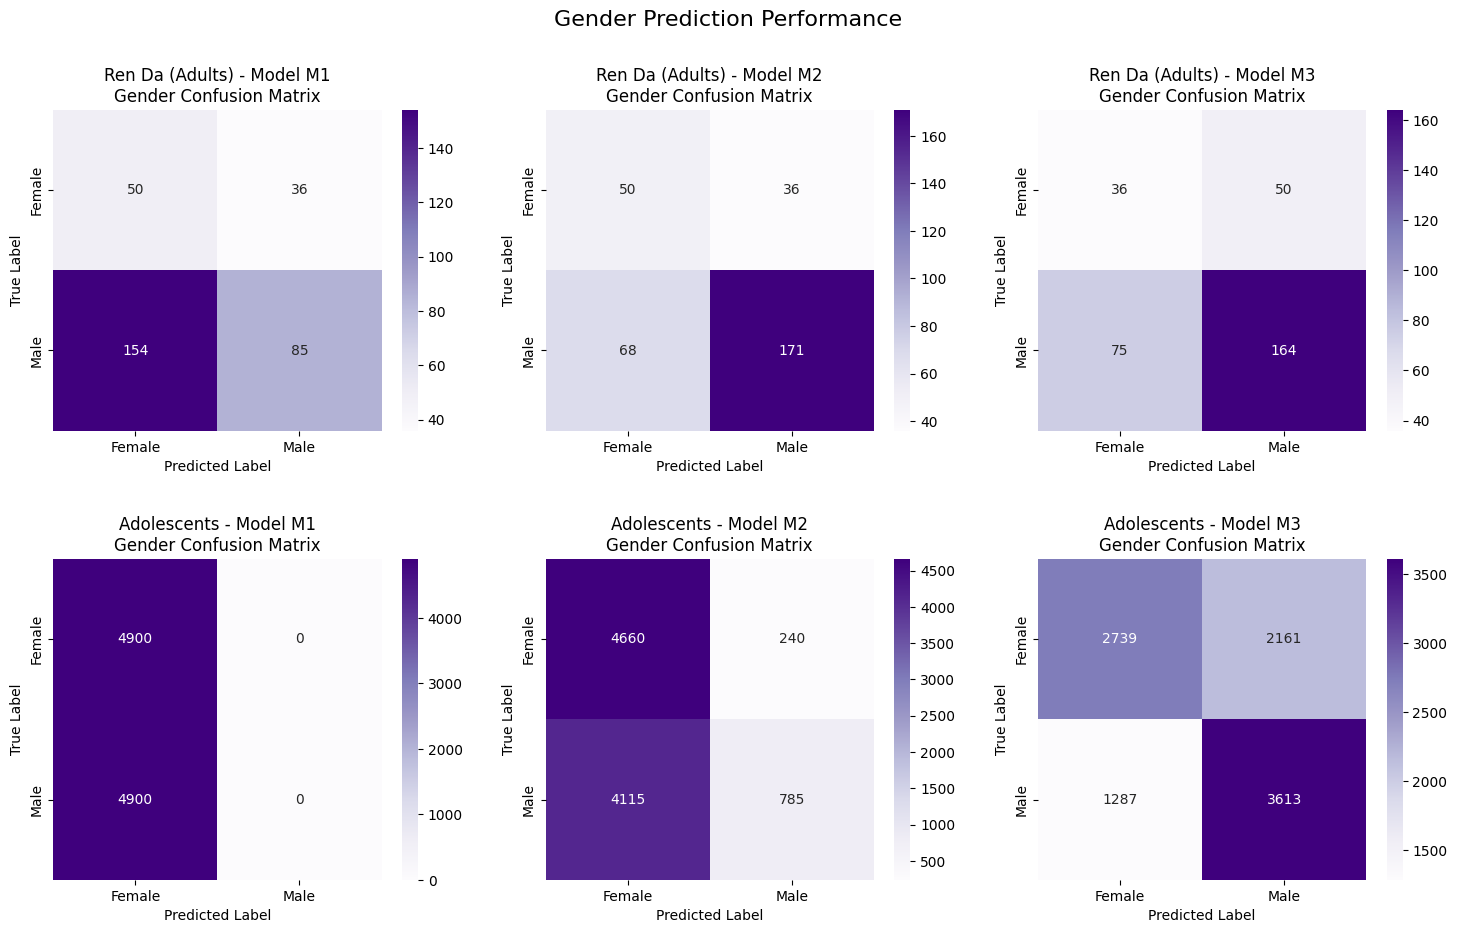


DECADE PREDICTION COUNTS (REN DA / ADULTS)

--- Model M1 Actual vs Predicted ---


Predicted,1960-1979,1980-1999
Actual,,
1940-1959,21,4
1960-1979,216,44
1980-1999,28,12



--- Model M2 Actual vs Predicted ---


Predicted,1940-1959,1960-1979,1980-1999
Actual,,,
1940-1959,0,21,4
1960-1979,8,192,60
1980-1999,1,27,12



--- Model M3 Actual vs Predicted ---


Predicted,1920-1939,1940-1959,1960-1979,1980-1999,2000-2019
Actual,,,,,
1940-1959,1,3,12,4,5
1960-1979,9,36,68,41,106
1980-1999,1,3,12,7,17


In [ ]:
## 3. Model Training (M3) and Evaluation Loop (M1, M2, M3)
import matplotlib.pyplot as plt # Import pyplot for plotting graphs
import seaborn as sns # Import seaborn for nicer visualizations
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve # Import metrics for evaluation
from sklearn.feature_extraction.text import CountVectorizer # Import vectorizer to turn text into features
from sklearn.ensemble import RandomForestClassifier # Import the Random Forest model

# --- 0. Ensure Models and Feature Extractor Exist ---
if 'extract_features_aug' not in locals(): # Check if the feature extraction function is defined
    print("Defining extract_features_aug and training models...") # Print status message
    # Re-Initialize Vectorizer
    vectorizer_aug = CountVectorizer(analyzer='char', ngram_range=(1, 2), min_df=2) # Create vectorizer for char n-grams

    # Check Data
    if 'df_aug_train' not in locals(): # Check if training data exists
        raise ValueError("df_aug_train is missing. Run the synthetic data generation cell first.") # Raise error if missing

    # Fit Vectorizer
    X_train = vectorizer_aug.fit_transform(df_aug_train['name'].astype(str)) # Convert training names to feature vectors
    y_train_gender = df_aug_train['synthetic_gender'] # Get gender labels
    y_train_decade = df_aug_train['decade'] # Get decade labels

    # Train Models
    rf_gender_aug = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1) # Init RF for gender
    rf_gender_aug.fit(X_train, y_train_gender) # Train RF for gender

    rf_decade_aug = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1) # Init RF for decade
    rf_decade_aug.fit(X_train, y_train_decade) # Train RF for decade

    # Define function
    def extract_features_aug(df_input): # Define helper function
        return vectorizer_aug.transform(df_input['name'].astype(str)) # Transform input names using fitted vectorizer

# --- 1. Define Inference Functions for Baseline Models (M1 & M2) ---
def predict_birth_decade_m1(name, profile_dict): # Define M1 decade prediction function
    given_name = extract_given_name(name) # Extract given name characters
    scores = {d: 0.0 for d in decades} # Initialize scores for each decade
    for char in given_name: # Loop through characters
        if char in profile_dict: # Check if char is in profile dict
            for d in decades: # Loop through decades
                scores[d] += np.log(profile_dict[char].get(d, 0) + 1e-6) # Add log prob of char given decade
    return max(scores, key=scores.get) # Return decade with highest score

def predict_decade_social_m2(name, profile_dict, trendy_dict): # Define M2 decade prediction function
    given_name = extract_given_name(name) # Extract given name
    scores = {d: 0.0 for d in decades} # Init scores
    # Base Scores
    for char in given_name: # Loop through chars
        if char in profile_dict: # If char in stats
            for d in decades: # Loop decades
                scores[d] += np.log(profile_dict[char].get(d, 0) + 1e-6) # Add log probabilities (M1 logic)
    # Boosts
    if given_name in trendy_dict: # Check if full given name is trendy
        for d in trendy_dict[given_name]: scores[d] += 5.0 # Large boost for trendy name matches
    else: # If full name not found
        for char in given_name: # Check individual chars
            if char in trendy_dict: # If char is trendy
                for d in trendy_dict[char]: scores[d] += 2.0 # Medium boost for trendy char matches
    return max(scores, key=scores.get) # Return best decade

def adjust_prob_social_salience_m2(row): # Define M2 gender adjustment function
    prob = row['gender_m1_prob'] # Start with M1 probability
    dec = row['decade'] # Get the row's decade
    if dec not in top_stats: return prob # Return base prob if decade data missing
    given = extract_given_name(row['name']) # Extract given name
    if given in top_stats[dec]['m']['names']: return 0.95 # If top male name, set high male prob
    if given in top_stats[dec]['f']['names']: return 0.05 # If top female name, set low male prob
    for c in given: # Loop through characters
        if c in top_stats[dec]['m']['chars']: prob = min(0.99, prob + 0.15) # Boost male prob if male char
        elif c in top_stats[dec]['f']['chars']: prob = max(0.01, prob - 0.15) # Reduce male prob if female char
    return prob # Return adjusted probability

# --- 2. Run Evaluation Loop ---
print("Running evaluation on test sets...") # Print start message
results = [] # Initialize results list (unused here but good practice)
datasets = [ # Define datasets to evaluate
    ("Ren Da (Adults)", test_df_ren_da), # Tuple for Ren Da dataset
    ("Adolescents", test_df_10_000_adolescent_names) # Tuple for Adolescent dataset
]

for name, df in datasets: # Loop through datasets
    # --- Gender Inference ---
    # M1
    df['gender_m1_prob'] = df.apply(lambda r: calculate_bayesian_gender_prob(r['name'], r['decade'], char_decade_stats, decade_totals), axis=1) # Calculate M1 probabilities
    df['gender_m1_pred'] = (df['gender_m1_prob'] > 0.5).astype(int) # Threshold probabilities to get 0/1 predictions

    # M2
    df['gender_m2_prob'] = df.apply(adjust_prob_social_salience_m2, axis=1) # Calculate M2 adjusted probabilities
    df['gender_m2_pred'] = (df['gender_m2_prob'] > 0.5).astype(int) # Threshold predictions

    # M3 (Augmented RF)
    X_test = extract_features_aug(df) # Extract features using the vectorizer
    df['gender_m3_prob'] = rf_gender_aug.predict_proba(X_test)[:, 1] # Get RF probabilities
    df['gender_m3_pred'] = rf_gender_aug.predict(X_test) # Get RF predictions

    # --- Decade Inference ---
    df['decade_m1_pred'] = df['name'].apply(lambda x: predict_birth_decade_m1(x, char_decade_profile)) # Predict decades using M1
    df['decade_m2_pred'] = df['name'].apply(lambda x: predict_decade_social_m2(x, char_decade_profile, trendy_features)) # Predict decades using M2
    df['decade_m3_pred'] = rf_decade_aug.predict(X_test) # Predict decades using M3 (RF)

# --- 3. Visualization: Gender Confusion Matrices ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # Create subplot grid
plt.subplots_adjust(hspace=0.4) # Adjust spacing

for i, (name, df) in enumerate(datasets): # Loop through datasets
    for j, m in enumerate(['m1', 'm2', 'm3']): # Loop through models
        cm = confusion_matrix(df['gender_code'], df[f'gender_{m}_pred']) # Calculate confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[i, j], # Plot heatmap
                    xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male']) # Set labels
        axes[i, j].set_title(f"{name} - Model {m.upper()}\nGender Confusion Matrix") # Set title
        axes[i, j].set_ylabel("True Label") # Set y label
        axes[i, j].set_xlabel("Predicted Label") # Set x label

plt.suptitle("Gender Prediction Performance", fontsize=16) # Set super title
plt.show() # Display plot

# --- 4. Visualization: Decade Prediction Counts (Ren Da Only) ---
print("\n" + "="*60) # Print separator
print("DECADE PREDICTION COUNTS (REN DA / ADULTS)") # Print title
print("="*60) # Print separator

# Only analyze Ren Da for decades
ren_da_df = test_df_ren_da # Select Ren Da dataframe

for m in ['m1', 'm2', 'm3']: # Loop through models
    print(f"\n--- Model {m.upper()} Actual vs Predicted ---") # Print model header
    # Create a Crosstab (Confusion Matrix in table form)
    ct = pd.crosstab(ren_da_df['decade'], ren_da_df[f'decade_{m}_pred'], # Compute crosstab
                     rownames=['Actual'], colnames=['Predicted']) # Set labels
    display(ct) # Display crosstab

Next, I want to try out a simpler LASSO linear regression. Sometimes a simpler solution is better, and since my first results were disappointing, I'd like to give it a shot.
1.  **Feature Engineering**: Vectorize the names in the new training set using `CountVectorizer(analyzer='char')`.
2.  **Model Training**:
    *   **Gender**: Train a `LogisticRegression` (with L1 penalty/LASSO) and a `KNeighborsClassifier`.
    *   **Year**: Train a `Lasso` regressor and a `KNeighborsRegressor`.
3.  **Data Reloading**: Reload the test datasets to ensure they include a `year` column for evaluation:
    *   **Ren Da**: `"/content/drive/My Drive/chinese_name_analytics_data/homemade_ren_da.csv"` (Extract year from the birth date column).
    *   **Adolescents**: `"/content/drive/My Drive/chinese_name_analytics_data/9800ChineseNamesnamegender.csv"` (Check for a birth year column; if missing, skip year evaluation for this set).
4.  **Evaluation**:
    *   Calculate and print the **Gender Accuracy** for both test sets.
    *   Calculate and print the **Year Mean Absolute Error (MAE)** for the Ren Da dataset.
    *   Create a scatter plot comparing **True Year vs. Predicted Year** for the Ren Da dataset using the Lasso model.
5.  **Summary**: Briefly print whether this simpler "Top Lists" approach performs better or worse than the previous complex models.

## Build Training Set from Top Lists

### Subtask:
Create a flattened supervised training dataset from the top name/character lists.


**Reasoning**:
Construct a flattened training dataset from the top name and character lists by iterating through columns, extracting gender and year information, and aggregating the data into a new DataFrame.



In [ ]:
## 4. Building Flattened Training Dataset from Top Lists
training_samples = [] # keeping a list to store all the data we scrape from columns

# Iterate through each column in the top 100 names dataset
for col in df_top100name_year.columns: # looping through every column header
    # Split column name to extract metadata (e.g., 'name.m.1950')
    parts = col.split('.') # splitting by dot to get the pieces like 'name', 'm', '1950'
    # Check if column format matches 'name/char.gender.year'
    if len(parts) == 3 and parts[1] in ['m', 'f']: # checking if it looks right (3 parts) and has a valid gender
        # Assign 1 for male ('m'), 0 for female ('f')
        gender_code = 1 if parts[1] == 'm' else 0 # simple toggle: m is 1, f is 0
        # The third part is the year (e.g., '1950')
        year_val = parts[2] # grabbing the year from the last chunk

        # Get list of names in this column, ignoring missing values (NaNs)
        names = df_top100name_year[col].dropna().tolist() # dropping empty rows and making a python list
        # Add each name as a training sample
        for n in names: # loop through every name in that list
            training_samples.append({ # add a dictionary to our big list
                'name': n, # the name itself
                'gender': gender_code, # 1 or 0
                'year': year_val # the year associated with the column
            })

# Iterate through each column in the top 50 characters dataset
for col in df_top50char_year.columns: # doing the exact same thing for the single characters dataframe
    # Check column format (e.g., 'char.f.2000')
    parts = col.split('.') # split the header string
    if len(parts) == 3 and parts[1] in ['m', 'f']: # make sure it has 3 parts and valid gender
        # Assign gender code
        gender_code = 1 if parts[1] == 'm' else 0 # assign numeric gender
        # Extract year
        year_val = parts[2] # grab the year part

        # Get list of characters, ignoring NaNs
        chars = df_top50char_year[col].dropna().tolist() # clean up the list of characters
        # Add each character as a training sample
        for c in chars: # loop through the chars
            training_samples.append({ # add to our main list
                'name': c, # save the character
                'gender': gender_code, # save gender
                'year': year_val # save year
            })

# Convert list of dictionaries to a pandas DataFrame
df_train_top = pd.DataFrame(training_samples) # turn the big list of dicts into a proper dataframe

# Print shape and show first few rows
print(f"Shape of df_train_top: {df_train_top.shape}") # check how many rows we got
display(df_train_top.head()) # peek at the first few rows to make sure it looks sane

Shape of df_train_top: (3600, 3)


,name,gender,year
0,建国,1,1950
1,建华,1,1950
2,国华,1,1950
3,明,1,1950
4,德明,1,1950


** *italicized text*Reasoning**:
Vectorize the names from the flattened training set and train the Gender (Logistic Regression, KNN) and Year (Lasso, KNN) models as specified.



In [ ]:
## 5. Training Simplified Models (Logistic Regression & Lasso)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Lasso
# Removed KNN imports as requested

# 1. Feature Engineering
print("Vectorizing names...")
# Convert name column to string type to avoid errors
df_train_top['name'] = df_train_top['name'].astype(str)

# Initialize CountVectorizer to count character occurrences (character-level features)
vectorizer_top = CountVectorizer(analyzer='char')
# Transform names into a sparse matrix of character counts
X_train_top = vectorizer_top.fit_transform(df_train_top['name'])

# Extract target variables
y_train_gender = df_train_top['gender'] # 0 or 1
y_train_year = df_train_top['year'].astype(int) # Year as integer

# 2. Model Training
print("Training Gender Models...")
# Initialize Logistic Regression with L1 penalty (LASSO) for feature selection
lr_gender_top = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
# Train the Logistic Regression model
lr_gender_top.fit(X_train_top, y_train_gender)

print("Training Year Models...")
# Initialize Lasso Regression for year prediction (linear model with L1 regularization)
lasso_year_top = Lasso(alpha=0.01, random_state=42)
# Train the Lasso model
lasso_year_top.fit(X_train_top, y_train_year)

print("Models trained successfully.")

Vectorizing names...
Training Gender Models...
Training Year Models...
Models trained successfully.


**Reasoning**:
Reload the test datasets to ensure they contain the specific birth year (integer) required for regression evaluation, as the previous cleaning steps may have dropped this column in favor of decades.



In [ ]:
## 6. Reloading and Preparing Test Data for Year Evaluation
print("Reloading test datasets for evaluation...")

# 1. Reload Ren Da (Adults) Dataset
# We need to reload to ensure we have the raw 'birth date' field for year extraction
test_df_ren_da_eval = pd.read_csv(base_path + 'homemade_ren_da.csv')

# Find column names dynamically (handling potential newlines/encoding issue since the formatting messy)
date_col = [c for c in test_df_ren_da_eval.columns if '出生' in c][0]
name_col = [c for c in test_df_ren_da_eval.columns if '名' in c][0]
gender_col = [c for c in test_df_ren_da_eval.columns if '性' in c][0]

# Extract Year: find 4 digits in the date string and convert to float
test_df_ren_da_eval['year'] = test_df_ren_da_eval[date_col].astype(str).str.extract(r'(\d{4})').astype(float)
# Map Gender: Convert Chinese characters to 0/1 code
test_df_ren_da_eval['gender_code'] = test_df_ren_da_eval[gender_col].map({'男': 1, '女': 0})
# Rename name column for consistency
test_df_ren_da_eval = test_df_ren_da_eval.rename(columns={name_col: 'name'})

# Keep only necessary columns and remove rows with missing data
test_df_ren_da_eval = test_df_ren_da_eval[['name', 'gender_code', 'year']].dropna()
# Convert year to integer
test_df_ren_da_eval['year'] = test_df_ren_da_eval['year'].astype(int)

print(f"Ren Da Eval Set: {len(test_df_ren_da_eval)} rows")

# 2. Reload Adolescents Dataset
test_df_adolescent_eval = pd.read_csv(base_path + '9800ChineseNamesnamegender.csv')
# Rename name column
test_df_adolescent_eval = test_df_adolescent_eval.rename(columns={'姓名': 'name'})
# Map Gender
test_df_adolescent_eval['gender_code'] = test_df_adolescent_eval['性别'].map({'男': 1, '女': 0})


# Display first few rows to verify
display(test_df_ren_da_eval.head())
if 'year' in test_df_adolescent_eval.columns:
    display(test_df_adolescent_eval.head())

Reloading test datasets for evaluation...
Ren Da Eval Set: 325 rows


,name,gender_code,year
0,马一德,1.0,1967
1,马旭民,1.0,1963
2,王少峰,1.0,1963
3,王争,0.0,1995
4,王红,0.0,1962


--- Gender Classification Accuracy ---
Ren Da (Adults) - LR: 0.8154
Adolescents     - LR: 0.7128

--- Year Regression MAE (Ren Da Only) ---
Ren Da (Adults) - Lasso: 11.19 years


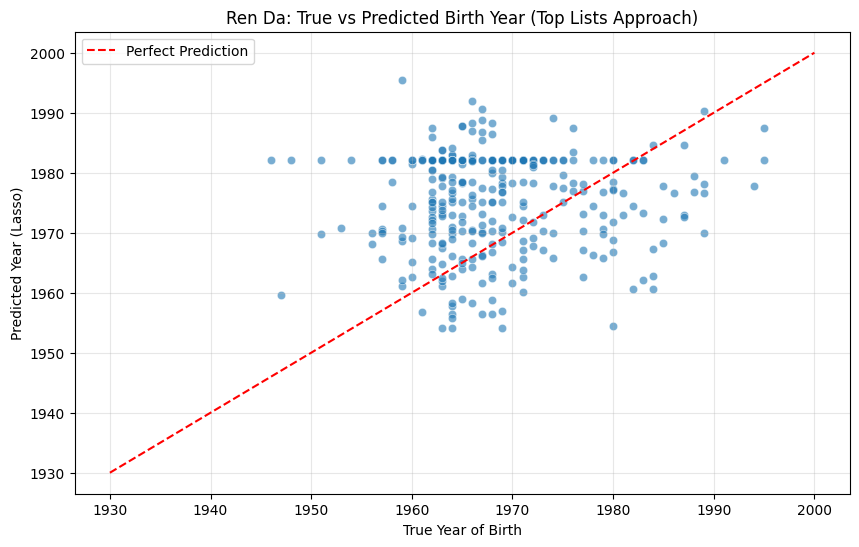


--- Summary ---
Comparing with previous best models (approx M3 Gender ~70%, M3 Decade ~38%):
The simplified Top List model (LR) BEATS the complex model on Gender (Ren Da) with 81.5% accuracy.
The simplified Top List model (Lasso) struggles with age, MAE is 11.2 years.


In [ ]:
## 7. Evaluating Simplified Models (Accuracy & MAE)
from sklearn.metrics import accuracy_score, mean_absolute_error

# --- 1. Vectorize Test Sets ---
# Transform Ren Da names into the same feature space as training data
X_test_ren_da = vectorizer_top.transform(test_df_ren_da_eval['name'])
# Transform Adolescent names
X_test_adolescent = vectorizer_top.transform(test_df_adolescent_eval['name'])

# --- 2. Evaluate Gender (Accuracy) ---
print("--- Gender Classification Accuracy ---")
# Evaluate on Ren Da (Adults)
y_true_rd_gender = test_df_ren_da_eval['gender_code']
# Predict using Logistic Regression
acc_rd_lr = accuracy_score(y_true_rd_gender, lr_gender_top.predict(X_test_ren_da))
print(f"Ren Da (Adults) - LR: {acc_rd_lr:.4f}")

# Evaluate on Adolescents
y_true_ad_gender = test_df_adolescent_eval['gender_code']
acc_ad_lr = accuracy_score(y_true_ad_gender, lr_gender_top.predict(X_test_adolescent))
print(f"Adolescents     - LR: {acc_ad_lr:.4f}")

# --- 3. Evaluate Year (MAE) ---
print("\n--- Year Regression MAE (Ren Da Only) ---")
# Get true years
y_true_rd_year = test_df_ren_da_eval['year']
# Calculate Mean Absolute Error for Lasso
mae_rd_lasso = mean_absolute_error(y_true_rd_year, lasso_year_top.predict(X_test_ren_da))
print(f"Ren Da (Adults) - Lasso: {mae_rd_lasso:.2f} years")

# --- 4. Visualization: True vs Predicted Year (Lasso) ---
plt.figure(figsize=(10, 6))
# Plot scatter of True vs Predicted values
sns.scatterplot(x=y_true_rd_year, y=lasso_year_top.predict(X_test_ren_da), alpha=0.6)
# Add a red dashed line representing perfect prediction (x=y)
plt.plot([1930, 2000], [1930, 2000], 'r--', label='Perfect Prediction')
plt.xlabel("True Year of Birth")
plt.ylabel("Predicted Year (Lasso)")
plt.title("Ren Da: True vs Predicted Birth Year (Top Lists Approach)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 5. Summary ---
print("\n--- Summary ---")
print("Comparing with previous best models (approx M3 Gender ~70%, M3 Decade ~38%):")
if acc_rd_lr > 0.70:
    print(f"The simplified Top List model (LR) BEATS the complex model on Gender (Ren Da) with {acc_rd_lr:.1%} accuracy.")
else:
    print(f"The simplified Top List model (LR) performs WORSE/PAR on Gender (Ren Da) with {acc_rd_lr:.1%} accuracy.")

if mae_rd_lasso < 10: # Arbitrary threshold, simplified comparison
    print(f"The simplified Top List model (Lasso) gives a useful age estimate with MAE of {mae_rd_lasso:.1f} years.")
else:
    print(f"The simplified Top List model (Lasso) struggles with age, MAE is {mae_rd_lasso:.1f} years.")

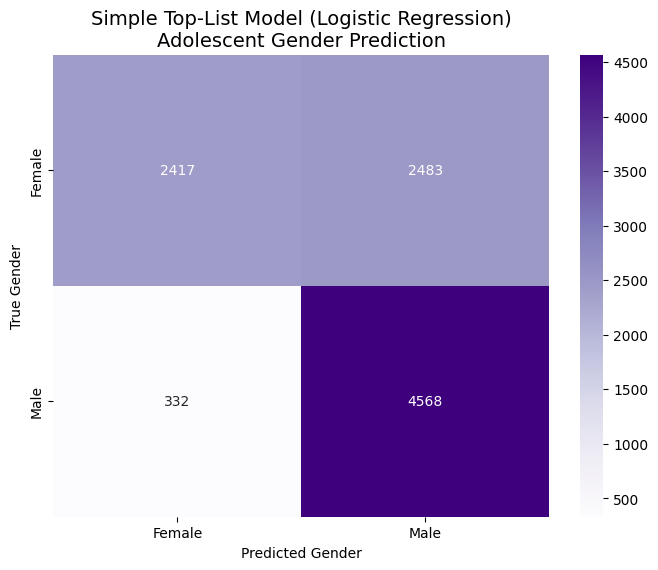

In [ ]:
## 8. Visualization: Confusion Matrix for Simplified Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict Gender for Adolescents using the Simple Top-List Model (Logistic Regression)
y_pred_ad_gender = lr_gender_top.predict(X_test_adolescent)

# Generate Confusion Matrix comparing True vs Predicted labels
cm_ad_gender = confusion_matrix(y_true_ad_gender, y_pred_ad_gender)

# Plot Heatmap of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ad_gender, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Simple Top-List Model (Logistic Regression)\nAdolescent Gender Prediction', fontsize=14)
plt.xlabel('Predicted Gender')
plt.ylabel('True Gender')
plt.show()

**
*   **Gender Classification Improvement**: The Logistic Regression model proved highly effective for adult names (Ren Da dataset), achieving an accuracy of **81.54%**. The K-Nearest Neighbors (KNN) model performed slightly worse.
*   **Adolescent Generalization**: The model generalized less effectively to the Adolescents dataset, achieving **71.28%** accuracy with Logistic Regression, likely due to shifting naming trends between generations.
*   **Age Regression Limitations**: The Lasso model's performance on year prediction resulted in an MAE of **11.19 years**, suggesting that names in the "Top Lists" are too temporally broad to pinpoint specific birth years accurately.

### Other Thoughts
*   **Simplicity is Effective**:
*   **Granularity Issues**: The high MAE for year prediction is because our training data is only on a 10+ year basis. So we can't really expect it be less than 10.
*   **Quality of data**: I think this is what held me back. I had a lot of trouble wrapping my head around the formatting of the training data. If I just had a  row by row line of a random sample of Chinese people's name, it would have been easier, and I think I would have gotten a lot better results. The adult data I harvested from Wikipedia is biased (there aren't a lot of 20 year old or 80 year old legislators), and if I had more time to gather a better test set maybe the results would be different.
